# Deep Learning for Fake News Detection

**Fake news classifier**: Train a text classification model to detect fake news articles!

* Download the dataset here: https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset
* Develop an NLP model for classification that uses a pretrained language model


**Setup notbook to use TPU:**

In [ ]:
import tensorflow as tf

# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


**Prepare and load data:**

In [ ]:
### prepare data

import pandas as pd

# # download original dataset
# !gdown --id 1MrvX7MPvkSogsSfvLK1XFfM1RGS9iNUB
# !gdown --id 1vj5HThNl8_FlFdKzhLN6Ti-BplL3qM89

# fake_news = pd.read_csv('Fake.csv')
# true_news = pd.read_csv('True.csv')

# fake_news['label'] = 1
# true_news['label'] = 0

# data = pd.concat([fake_news ,true_news])
# data = data.sample(frac=1)

# train = pd.DataFrame(data.values[:int(len(data) * 0.9)], columns=['title', 'text', 'subject', 'date', 'label'])
# test = pd.DataFrame(data.values[int(len(data) * 0.9):], columns=['title', 'text', 'subject', 'date', 'label'])
# valid = pd.DataFrame(train.values[int(len(train) * 0.9):], columns=['title', 'text', 'subject', 'date', 'label'])
# train = train.loc[~train.index.isin(valid.index)]

# train.to_csv('train.csv')
# valid.to_csv('valid.csv')
# test.to_csv('test.csv')

# download prepared dataset
!gdown --id 1KipcGINFYbUAXRuIWOCOxOGC4Pyk7szl
!gdown --id 1zDlcNz4Xa3aRZJGcNvyvOG26tdWd879B
!gdown --id 1HsDbjjeOI7O_bKNvvwJmS81n7-zmOPLG

train = pd.read_csv('train.csv')
valid = pd.read_csv('valid.csv')
test = pd.read_csv('test.csv')

Downloading...
From: https://drive.google.com/uc?id=1KipcGINFYbUAXRuIWOCOxOGC4Pyk7szl
To: /content/train.csv
100% 94.6M/94.6M [00:00<00:00, 148MB/s]
Downloading...
From: https://drive.google.com/uc?id=1zDlcNz4Xa3aRZJGcNvyvOG26tdWd879B
To: /content/valid.csv
100% 10.3M/10.3M [00:00<00:00, 107MB/s]
Downloading...
From: https://drive.google.com/uc?id=1HsDbjjeOI7O_bKNvvwJmS81n7-zmOPLG
To: /content/test.csv
100% 11.5M/11.5M [00:00<00:00, 63.1MB/s]


**Model training:**

In [ ]:
!pip install transformers
!pip install SentencePiece

In [ ]:
from transformers import *

In [ ]:
MODEL_NAME = 'bert-base-uncased'
MAX_LEN = 32
DROPOUT = 0.5

In [ ]:
def prepare_dataset(data, tokenizer, max_len):

  ids = []
  masks = []
  labels = []
  token_ids = []

  labels = []
  
  for row in data.itertuples():
    text = row.text
    inputs = tokenizer(text, None, max_length=max_len, pad_to_max_length=True, truncation=True, return_attention_mask=True, return_token_type_ids=True, add_special_tokens=True)
    ids.append(inputs['input_ids'])
    masks.append(inputs['attention_mask'])
    token_ids.append(inputs['token_type_ids'])

    labels.append(row.label)

  return {
      'input_ids': ids,
      'attention_mask': masks,
      'token_type_ids': token_ids,
      'labels': labels
      }

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, pad_token='[PAD]')

loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.18.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file https://huggingface.co/bert-base-uncased/resolve/ma

In [ ]:
training_set = prepare_dataset(train, tokenizer, MAX_LEN)
validating_set = prepare_dataset(valid, tokenizer, MAX_LEN)
testting_set = prepare_dataset(test, tokenizer, MAX_LEN)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import * 
from tensorflow.keras import optimizers, losses
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import Recall, Precision

In [ ]:
def get_model():

  input_ids = Input(shape=(MAX_LEN,), dtype=tf.int32)
  attention_mask = Input(shape=(MAX_LEN,), dtype=tf.int32)
  token_type_ids = Input(shape=(MAX_LEN,), dtype=tf.int32)

  encoder = TFAutoModel.from_pretrained(MODEL_NAME, return_dict=True)

  sequence_outputs = encoder({"input_ids": input_ids, "token_type_ids": token_type_ids, "attention_mask": attention_mask}, training=True).last_hidden_state

  conv1_layer = Conv1D(filters=32, kernel_size=3, strides=2, padding='valid', activation='relu')(sequence_outputs)
  pool_layer1 = MaxPooling1D()(conv1_layer)

  flat_layer = Flatten()(pool_layer1)
  dense_layer = Dense(128, activation="relu")(flat_layer)
  drop_out = Dropout(DROPOUT)(dense_layer)
  output = Dense(2, activation='softmax')(drop_out)
    
  model = Model(inputs=[input_ids, attention_mask, token_type_ids], outputs=output) 

  optimizer = optimizers.Adam(lr=2e-5)
  loss = losses.binary_crossentropy

  model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy', Recall(), Precision()])

  model.summary()

  return model

loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.18.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file https://huggingface.co/bert-base-uncased/re

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32)]         0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 32)]         0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 32)]         0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_2[0][0]',                
                                thPoolingAndCrossAt               'input_1[0][0]',            

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


                                                                                                  
 dense (Dense)                  (None, 128)          28800       ['flatten[0][0]']                
                                                                                                  
 dropout_37 (Dropout)           (None, 128)          0           ['dense[0][0]']                  
                                                                                                  
 dense_1 (Dense)                (None, 2)            258         ['dropout_37[0][0]']             
                                                                                                  
Total params: 109,585,058
Trainable params: 109,585,058
Non-trainable params: 0
__________________________________________________________________________________________________


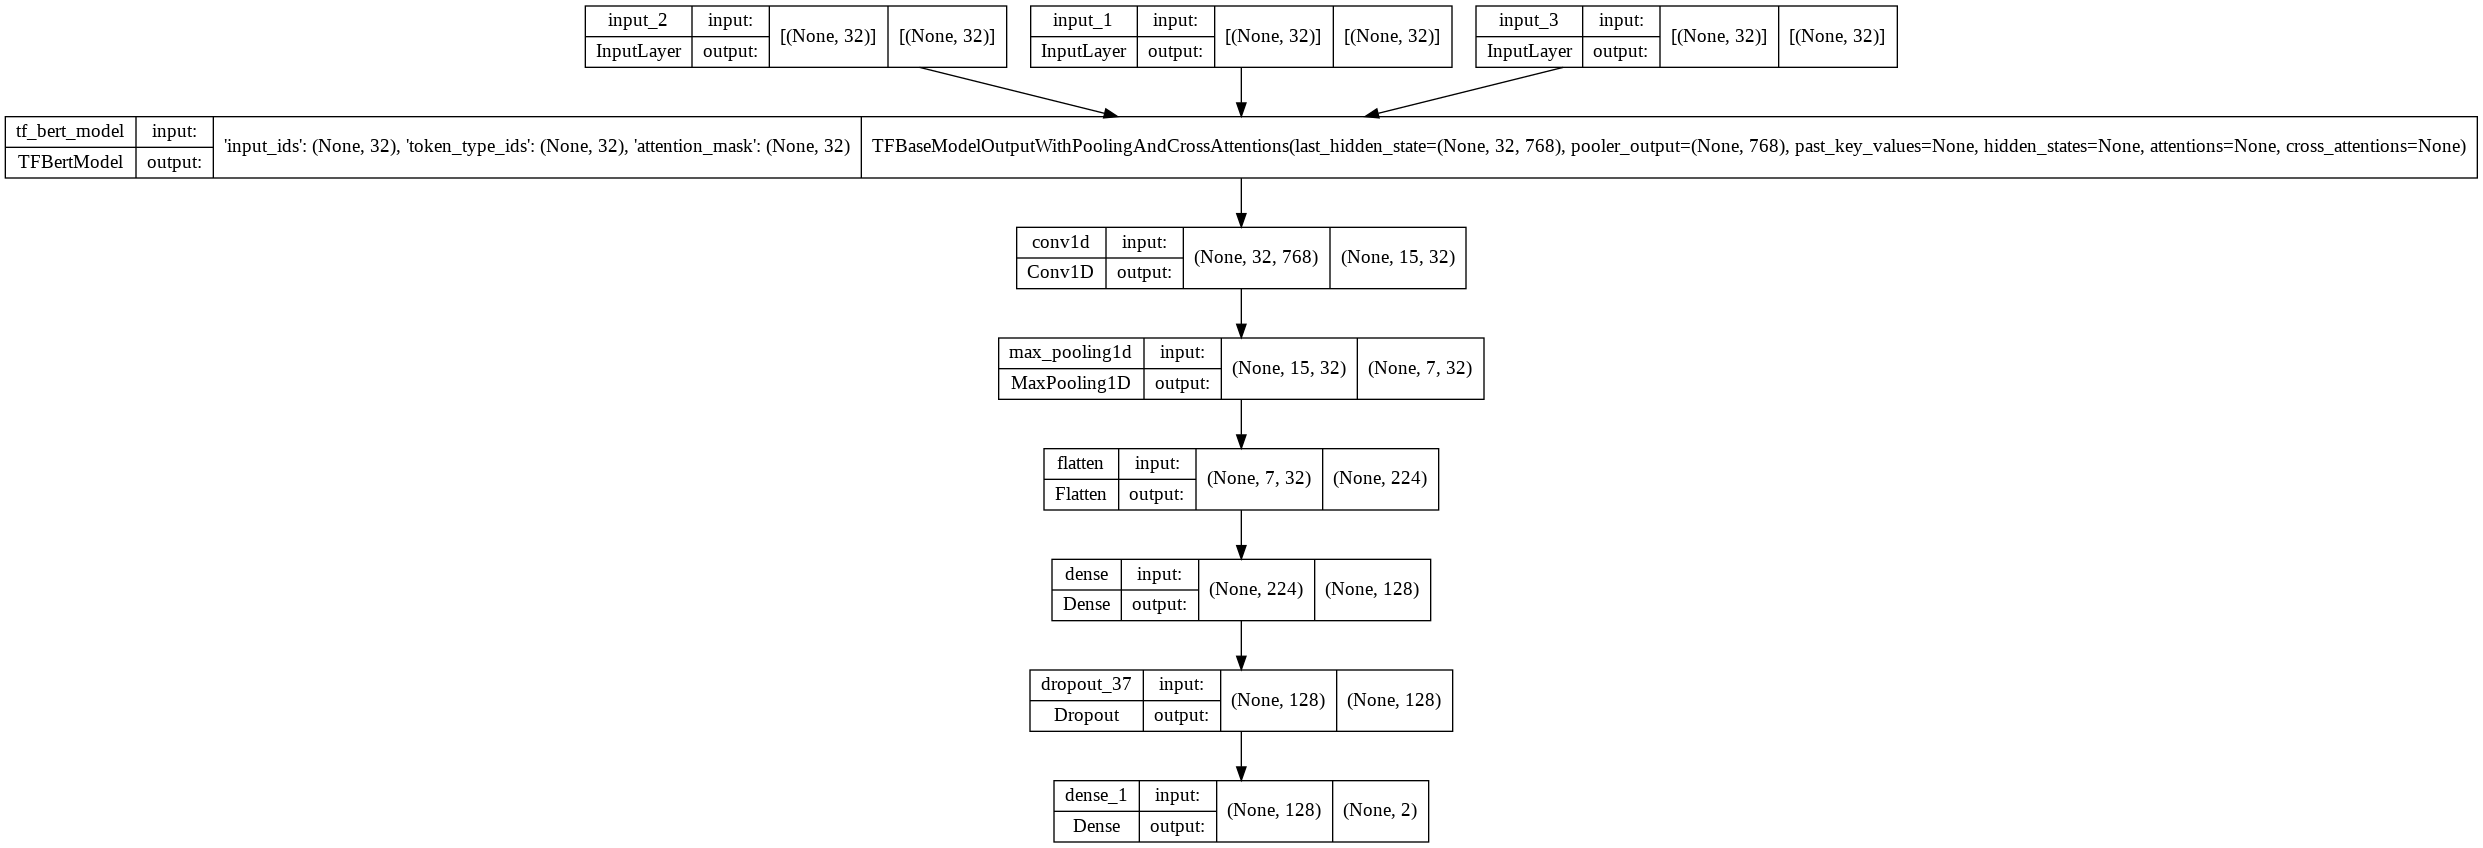

In [ ]:
from tensorflow.keras.utils import to_categorical
import numpy as np 

x_train = [np.array(training_set['input_ids'], dtype=int), np.array(training_set['attention_mask'], dtype=int), np.array(training_set['token_type_ids'], dtype=int)]
x_valid = [np.array(validating_set['input_ids'], dtype=int), np.array(validating_set['attention_mask'], dtype=int), np.array(validating_set['token_type_ids'], dtype=int)]
x_test = [np.array(testting_set['input_ids'], dtype=int), np.array(testting_set['attention_mask'], dtype=int), np.array(testting_set['token_type_ids'], dtype=int)]

y_train = np.array(to_categorical(training_set['labels']), dtype=int)
y_valid = np.array(to_categorical(validating_set['labels']), dtype=int)
y_test = np.array(to_categorical(testting_set['labels']), dtype=int)


with strategy.scope():
    model = get_model()

model.summary()
tf.keras.utils.plot_model(model, to_file='./model.png', show_shapes=True)

In [ ]:
history = model.fit(
    x_train,
    y_train,
    validation_data = (x_valid, y_valid),
    epochs=5,
    verbose=1,
    batch_size=200)

Epoch 1/5
182/182 [==============================] - 440s 2s/step - loss: 0.0847 - accuracy: 0.9725 - recall: 0.9725 - precision: 0.9725 - val_loss: 0.0041 - val_accuracy: 0.9995 - val_recall: 0.9995 - val_precision: 0.9995
Epoch 2/5
182/182 [==============================] - 414s 2s/step - loss: 0.0073 - accuracy: 0.9993 - recall: 0.9993 - precision: 0.9993 - val_loss: 0.0053 - val_accuracy: 0.9993 - val_recall: 0.9993 - val_precision: 0.9993
Epoch 3/5
182/182 [==============================] - 414s 2s/step - loss: 0.0047 - accuracy: 0.9994 - recall: 0.9994 - precision: 0.9994 - val_loss: 0.0022 - val_accuracy: 0.9998 - val_recall: 0.9998 - val_precision: 0.9998
Epoch 4/5
182/182 [==============================] - 414s 2s/step - loss: 0.0027 - accuracy: 0.9995 - recall: 0.9995 - precision: 0.9995 - val_loss: 0.0023 - val_accuracy: 0.9998 - val_recall: 0.9998 - val_precision: 0.9998
Epoch 5/5
182/182 [==============================] - 414s 2s/step - loss: 9.5847e-04 - accuracy: 0.9999 

**Testing the trained model:**

Test Accuracy: 0.9997772828507795
Test Recall: 0.9997772828507795
Test Precision: 0.9997772828507795
Test F1-Score: 0.9997772828507795


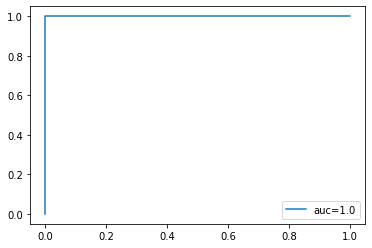

In [ ]:
from sklearn.metrics import *
import matplotlib.pyplot as plt

predicts = model.predict(x_test)
pred_labels = [np.argmax(predicts[i]) for i in range(len(testting_set['labels']))]
pred_prob = [predicts[i][1] for i in range(len(testting_set['labels']))]

print('Test Accuracy:', accuracy_score(testting_set['labels'], pred_labels))
print('Test Recall:', recall_score(testting_set['labels'], pred_labels, average='micro'))
print('Test Precision:', precision_score(testting_set['labels'], pred_labels, average='micro'))
print('Test F1-Score:', f1_score(testting_set['labels'], pred_labels, average='micro'))

fpr, tpr, _ = roc_curve(testting_set['labels'],  pred_prob)
auc = roc_auc_score(testting_set['labels'], pred_prob)

plt.plot(fpr, tpr, label="auc=" + str(auc))
plt.legend(loc=4)
plt.show()

**Some examples of misclassified news articles:**

In [ ]:
misclassified = {i: (v, pred_labels[i]) for i, v in enumerate(testting_set['labels']) if v != pred_labels[i]}

print(misclassified)

test.iloc[[list(misclassified.keys())[0]]]

{2350: (0, 1)}


,Unnamed: 0,title,text,subject,date,label
2350,2350,White House unveils list of ex-lobbyists grant...,The White House on Wednesday disclosed a group...,politicsNews,"June 1, 2017",0


In [ ]:
print('Number of words in misclassified news article:', len(test.iloc[[list(misclassified.keys())[0]]].text.values[0].split(' ')))

Number of words in misclassified news article: 532


**To improve the model:**

*   We can improve the model by feeding the news title as an input, applying a convolutional network on both inputs, i.e., the news text and the news title, and finally, concatenating the outputs of the two networks to feed the dense layer for classification.
*   It may be possible to classify this news article correctly by increasing the value of parameter MAX_LEN since it contains 532 words.
*   News keywords can be extracted from the news text and given to the model as an additional feature.

